In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
start_line = 6

data = pd.read_csv('Thesis_Samples_Data/Notched_Cast_6/Notched_Cast_6.csv', skiprows=start_line)
data = data.drop([0])
data

,Crosshead,Load,Time,Extensometer
1,0,-0.299609661,0.02,-6.75E-05
2,0,-0.387948692,0.039999999,-7.05E-05
3,0,-0.349657714,0.059999999,-6.78E-05
4,0,-0.204922199,0.079999998,-7.15E-05
5,-4.88E-05,-0.256271869,0.100000001,-6.95E-05
...,...,...,...,...
2017,-0.067236331,0.518726945,40.34000015,0.687413209
2018,-0.067285153,0.494915277,40.36000061,0.687405409
2019,-0.067333982,0.499047458,40.38000107,0.687415712
2020,-0.067333982,0.399697721,40.40000153,0.687425258


17.27143288


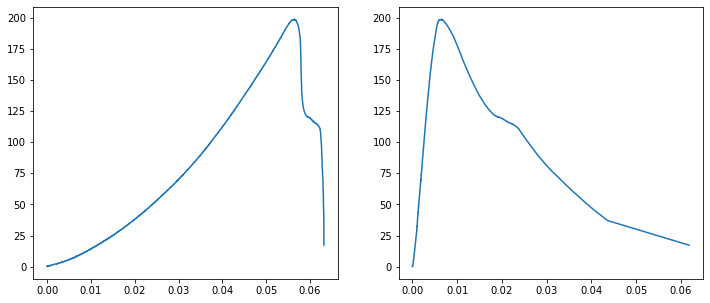

In [3]:
# get relevant columns and preprocess
crosshead = data.loc[:, 'Crosshead '].to_numpy(dtype=np.double)
extenso = data.loc[:, 'Extensometer '].to_numpy(dtype=np.double)
load = data.loc[:, 'Load '].to_numpy(dtype=np.double)

crosshead = abs(crosshead)

min_extenso = np.min(extenso)
if (min_extenso < 0):
    extenso = extenso + abs(min_extenso)
extenso = abs(extenso)

load = abs(load)

stop_index = 1903 - start_line
crosshead = crosshead[0:stop_index]
extenso = extenso[0:stop_index]
load = load[0:stop_index]

print(load[-1])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(crosshead, load)

plt.subplot(1, 2, 2)
plt.plot(extenso, load)

### Define Sample Parameters

In [4]:
S = 90      # span, mm
B = 32.35   # width, mm
B_N = B      # side-groove width, mm
W = 26.15   # thickness, mm
a0 = 0.75   # initial crack length, mm
E = 22500    # young's modulous, MPa


## K<sub>ic</sub> Calculation

![title](img/K_ic.png)

Where K<sub>(i)</sub> = K<sub>ic</sub>, P<sub>i</sub> = P<sub>max</sub> (the first, highest peak), and 
![title](img/f_a_W.png)

with a<sub>i</sub> = a<sub>0</sub>

[From E1820]

In [13]:
a_W = a0/W
f_aW = 3*np.sqrt(a_W) * (1.99 - a_W*(1-a_W)*(2.15-3.93*a_W+2.7*a_W**2)) / (2*(1+2*a_W)*np.power(1-a_W, 1.5))

P_max = np.max(load)
pl_index = np.argmax(load)

K_ic = (P_max*S/(np.sqrt(B*B_N)*np.power(W, 1.5))) * f_aW
K_ic

2.004390671848772

## J<sub>el</sub> Calculation

![title](img/J_el.png)

[from Bouville et al]

E is the young's modulous, so it must first be calulated from the (roughly) linear region before the first peak:

![title](img/modulous.png)

![title](img/wikipedia_terms.png)

[from Wikipedia]

In [63]:
# first find slope of linear load-displacement region
num_reg_points = int(pl_index / 5)
crosshead_reg = crosshead[pl_index-num_reg_points:pl_index]
load_reg = load[pl_index-num_reg_points:pl_index]
A = np.vstack([crosshead_reg, np.ones(len(crosshead_reg))]).T
m, c = np.linalg.lstsq(A, load_reg, rcond=None)[0]

# then calculate E
E_reg = (S**3 * m) / (4*B*W**3)
print(E_reg)

# finally J_el
J_el = K_ic**2/E_reg
J_el

1777.0774180326234


0.00226078049533834

5640.637311032226


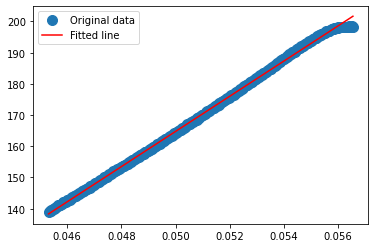

In [64]:
print(m)

_ = plt.plot(crosshead_reg, load_reg, 'o', label='Original data', markersize=10)
_ = plt.plot(crosshead_reg, m*crosshead_reg + c, 'r', label='Fitted line')
_ = plt.legend()
plt.show()

## J<sub>pl</sub> Calculation (using crosshead)

![title](img/J_pl_Bouville.png)

Where A<sub>pl</sub> is the cumulative area under the load-crosshead curve post-peak (after initial max load point) and is calculated using a trapezoidal sum. b = W - a<sub>0</sub>.

[from Bouville et al]

In [15]:
crosshead_pl = crosshead[pl_index:]
extenso_pl = extenso[pl_index:]
load_pl = load[pl_index:]

n_pl = load_pl.shape[0]
A_pl = np.zeros(n_pl)

A_pl[0] = 0.5*(load[pl_index]+load[pl_index-1]) * (crosshead[pl_index]-crosshead[pl_index-1])
for i in range(1, n_pl):
    A_pl[i] = A_pl[i-1] + 0.5*(load_pl[i]+load_pl[i-1]) * (crosshead[i]-crosshead[i-1])
    
J_pl = 1.9*A_pl/(B*(W-a0))

## Crack Length Determination (using crosshead)

To plot an R-curve, K<sub>jc</sub> must be plotted against the crack length a<sub>i</sub>:

![title](img/crack_length_Bouville.png)

with

![title](img/C_Bouville.png)

where u = crosshead displacement and f = load

[from Bouville et al]

In [66]:
C = np.divide(crosshead_pl, load_pl)

a = np.zeros(n_pl)

a[0] = a0
for i in range(1, n_pl):
    a[i] = a[i-1] + 0.5*(W-a[i-1])*((C[i]-C[i-1])/C[i])
    

## Crack Length Determination (using CMOD)

An alternative method, using equations from ASTM E399

![title](img/a_E399.png)

with

![title](img/E_prime.png)

In [76]:
B_e = B-((B-B_N)**2)/B

U = 1/(1+np.sqrt((E_reg*B_e*extenso_pl*1e1/load_pl)) * 4*W/S)

# a = (a/W)*W

a_E399 = W*(1 - 3.950*U + 2.982*np.power(U, 2) - 3.214*np.power(U, 3) + 5.516*np.power(U, 4) - 113.031*np.power(U, 5))

offset = abs(a_E399[0] - a0)
print(offset)
if (a_E399[0] < a0): a_E399 = a_E399 + offset
else: a_E399 = a_E399 - offset

# compare
print(a)
print(a_E399)

9.868037990393535
[ 0.75        0.77006181  0.78828567  0.78098964  0.80177286  0.82199161
  0.83121291  0.85824481  0.87092657  0.87987868  0.89322441  0.92897382
  0.95267266  0.98168546  1.00318689  1.01426915  1.04806196  1.07897169
  1.09835977  1.11859482  1.14841108  1.17186073  1.19687032  1.23751896
  1.25478826  1.29005935  1.35173876  1.39012687  1.44633633  1.49438161
  1.56178645  1.61879049  1.67451166  1.74865512  1.80041543  1.87120084
  1.96882928  2.06517589  2.20268112  2.45514778  2.8825082   3.2658807
  3.57437084  4.059872    4.4062263   4.70411001  4.9688429   5.16927667
  5.32827651  5.44161074  5.53607872  5.64480534  5.77626822  5.88336603
  5.94582177  6.00324002  6.06530562  6.12324037  6.17855674  6.23251758
  6.27750975  6.30034579  6.3584727   6.39813937  6.42048177  6.45267849
  6.48372453  6.53705741  6.56128897  6.57848022  6.61175072  6.61904904
  6.6489926   6.68567189  6.69981025  6.70646865  6.72356554  6.75701825
  6.78287818  6.78494297  6.788503

## K<sub>jc</sub> Calculation

![title](img/K_jc_Bouville.png)

This is an elemnt-wise calculation for plotting during the plastic region. An overall K<sub>jc</sub> can be found by taking the last/maximum value from this array.

[from Bouville et al]

In [77]:
K_jc = np.sqrt((J_el+J_pl)*E_reg)
K_jc_overall = np.max(K_jc)
K_jc_overall

2.7361670364590522

## Plotting

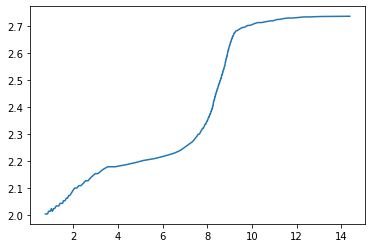

In [78]:
plt.plot(a_E399, K_jc)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

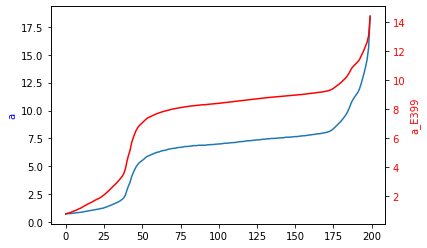

In [79]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(a)
ax1.set_ylabel('a', color='b')

ax2 = ax1.twinx()
ax2.plot(a_E399, 'r-')
ax2.set_ylabel('a_E399', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
plt.plot